<a href="https://www.kaggle.com/code/rana2hin/fdia-final?scriptVersionId=238223841" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np

merged_data = pd.read_parquet('/kaggle/input/fdia-sample-dataset-simbench/merged_data.parquet')
lines_sub = pd.read_parquet('/kaggle/input/fdia-sample-dataset-simbench/lines_sub.parquet')

merged_data.info()
lines_sub.info()

merged_data.head()
lines_sub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24192 entries, 0 to 24191
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   time     24192 non-null  datetime64[us]
 1   id       24192 non-null  object        
 2   node     24192 non-null  object        
 3   profile  24192 non-null  object        
 4   pRES     24192 non-null  float64       
 5   value    24192 non-null  float64       
 6   p_t      24192 non-null  float64       
dtypes: datetime64[us](1), float64(3), object(3)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          20 non-null     object 
 1   nodeA       20 non-null     object 
 2   nodeB       20 non-null     object 
 3   type        20 non-null     object 
 4   length      20 non-null     float64
 5   loadingMax  20 non-nu

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,nodeA,nodeB,type,length,loadingMax,subnet,voltLvl,r,x,b,iMax,type.y
0,EHV Line 229,EHV Bus 2578,EHV Bus 2579,LineType_4,48.848000,100.0,EHV1,1.0,0.033333,0.333333,3.22799,1950.0,ohl
1,dcline 3,EHV Bus 49,EHV Bus 499,dcline 1_type,540.000000,100.0,EHV1,1.0,NaN,NaN,NaN,NaN,None
2,HV1 Line 127,HV1 Bus 320,HV1 Bus 326,Al/St_265/35,0.997712,100.0,HV1,3.0,0.109500,0.296000,2.82740,680.0,ohl
3,HV1 Line 131,HV1 Bus 321,HV1 Bus 330,Al/St_265/35,3.210640,100.0,HV1,3.0,0.109500,0.296000,2.82740,680.0,ohl
4,HV1 Line 140,HV1 Bus 319,HV1 Bus 339,Al/St_265/35,3.546510,100.0,HV1,3.0,0.109500,0.296000,2.82740,680.0,ohl


In [2]:
merged_data.head()

,time,id,node,profile,pRES,value,p_t
0,2015-12-31 18:00:00,EHV Sgen 228,EHV Bus 2579,WP2,0.0,0.983439,0.000000
1,2015-12-31 18:00:00,EHV Sgen 230,EHV Bus 2578,WP2,0.0,0.983439,0.000000
2,2015-12-31 18:00:00,HV1 Sgen 108,HV1 Bus 323,WP4,68.8,0.980906,67.486333
3,2015-12-31 18:00:00,HV1 Sgen 114,HV1 Bus 330,WP4,18.0,0.980906,17.656308
4,2015-12-31 18:00:00,HV1 Sgen 122,HV1 Bus 342,WP4,10.0,0.980906,9.809060


In [3]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 4.8 MB/s eta 0:00:00


In [4]:
# ========================
# Step 0: Import Libraries
# ========================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Dense, LSTM, Dropout, Concatenate,
                                     Reshape, Flatten, BatchNormalization,
                                     LeakyReLU, Activation)
from tensorflow.keras.optimizers import Adam

# For the GNN, we use Spektral (install via: pip install spektral)
from spektral.layers import GCNConv

# For evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ===============================
# Step 1: Data Loading & Preprocessing
# ===============================
# Example: load your measurement and topology data (adjust file paths as needed)
measurement_df = pd.read_csv('/kaggle/input/simbench-sample-data/measurements.csv', parse_dates=['time'])
topology_df = pd.read_csv('/kaggle/input/simbench-sample-data/topology.csv')
original_df = measurement_df.copy()

# FDIA simulation parameters
attack_ratio = 0.3  # 30% of data is compromised
max_attack_strength = 0.4  # Maximum perturbation (40% deviation)

# Generate attack targets
n_samples = len(measurement_df)
attack_indices = np.random.choice(n_samples, size=int(n_samples * attack_ratio), replace=False)

# Simulate FDIA attacks
for idx in attack_indices:
    # Randomly select feature to attack (pRES or value)
    if np.random.rand() < 0.5:
        # Attack pRES
        perturbation = 1 + (np.random.rand() - 0.5) * 2 * max_attack_strength
        measurement_df.loc[idx, 'pRES'] *= perturbation
    else:
        # Attack value
        perturbation = 1 + (np.random.rand() - 0.5) * 2 * max_attack_strength
        measurement_df.loc[idx, 'value'] *= perturbation
    
    # Recalculate p_t to maintain consistency
    measurement_df.loc[idx, 'p_t'] = measurement_df.loc[idx, 'pRES'] * measurement_df.loc[idx, 'value']

# Create labels: 1 for attacked samples, 0 for normal
y = np.zeros(n_samples)
y[attack_indices] = 1

# Use attacked measurements for model input
measurement_features = ['pRES', 'value', 'p_t']
X_measure = measurement_df[measurement_features].values

# Normalize using robust scaling (more resistant to outliers)
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_measure = scaler.fit_transform(X_measure)

# For the GNN, you need a graph structure.
# For example, create an adjacency matrix from topology_df. (This is highly domain dependent.)
# Here we assume that each row in topology_df represents an edge between nodeA and nodeB.
# We first build a mapping from node ID to index:
nodes = pd.unique(topology_df[['nodeA', 'nodeB']].values.ravel())
node_to_index = {node: idx for idx, node in enumerate(nodes)}
n_nodes = len(nodes)

# Create a simple binary adjacency matrix
adjacency = np.zeros((n_nodes, n_nodes))
for _, row in topology_df.iterrows():
    i = node_to_index[row['nodeA']]
    j = node_to_index[row['nodeB']]
    adjacency[i, j] = 1
    adjacency[j, i] = 1  # assume undirected graph

In [11]:
# ===============================
# Step 2: Build the Autoencoder (AE)
# ===============================
def build_autoencoder(input_dim, encoding_dim=16):
    input_layer = Input(shape=(input_dim,))
    # Encoder
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    # Decoder
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

input_dim = X_measure.shape[1]

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1) Split into train/test (stratified to keep class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X_measure, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Train AE on NORMAL samples only (y_train == 0)
X_train_norm = X_train[y_train == 0]

from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping: stop after 5 epochs with no improvement in val_loss
es = EarlyStopping(
    monitor='val_loss',       # track validation loss (MSE)
    patience=5,               # wait 5 epochs for improvement
    restore_best_weights=True # roll back to the best weights
)

# Retrain autoencoder with EarlyStopping
autoencoder, ae_encoder = build_autoencoder(input_dim, encoding_dim=16)
ae_history = autoencoder.fit(
    X_train_norm, X_train_norm,
    epochs=100,               # a large max so ES can kick in
    batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)

# 3) Compute reconstruction errors on TRAIN set (for thresholding)
X_train_pred = autoencoder.predict(X_train_norm)
mse_train = np.mean(np.square(X_train_norm - X_train_pred), axis=1)

# 4) Choose threshold (e.g. 95th percentile of train‐MSE)
threshold = np.percentile(mse_train, 95)
print(f"Reconstruction error threshold: {threshold:.5f}")

# 5) Compute reconstruction errors on TEST set
X_test_pred = autoencoder.predict(X_test)
mse_test = np.mean(np.square(X_test - X_test_pred), axis=1)

# 6) Predict: 1 if error > threshold, else 0
y_pred = (mse_test > threshold).astype(int)

# 7) Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAE_Classification Report:\n",
      classification_report(
          y_test, y_pred,
          target_names=['Normal', 'Attacked'],
          digits=4
      ))


Epoch 1/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3536 - val_loss: 0.9206
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8698 - val_loss: 0.8318
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8646 - val_loss: 0.8145
Epoch 4/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8416 - val_loss: 0.8081
Epoch 5/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7800 - val_loss: 0.8052
Epoch 6/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8243 - val_loss: 0.8038
Epoch 7/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7915 - val_loss: 0.8030
Epoch 8/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8110 - val_loss: 0.8026
Epoch 9/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7944 - val_loss: 0.8023
Epoch 10/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7749 - val_loss: 0.8021
Epoch 11/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8374 - val_loss: 0.8020
Epoch 12/100
382/382 ━━━━━━━━━━━━━━━━━━━━

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.9872 - mae: 0.7900
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9859 - mae: 0.7893
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9845 - mae: 0.7887
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9833 - mae: 0.7881
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9821 - mae: 0.7876
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9811 - mae: 0.7871
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9802 - mae: 0.7866
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9794 - mae: 0.7862
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9787 - mae: 0.7859
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9783 - mae: 0.7856
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9780 - mae: 0.7855
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9778 - mae: 0.7854
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.977

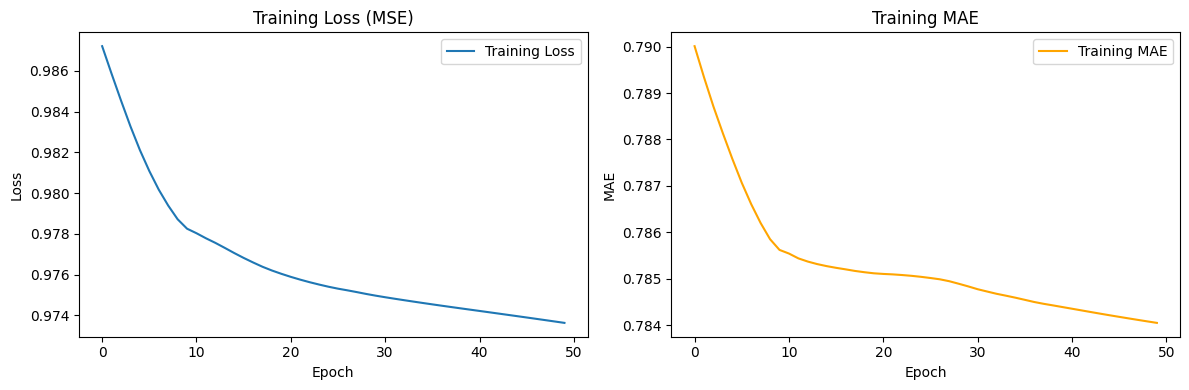

In [29]:
# ===============================
# Step 3: Build the Graph Neural Network (GNN)
# ===============================
import tensorflow as tf
from tensorflow.keras import Model, Input
from spektral.layers import GCNConv
import numpy as np

class CustomGCNConv(GCNConv):
    def compute_output_shape(self, input_shapes):
        features_shape = input_shapes[0]
        return (features_shape[0], features_shape[1], self.channels)
        
    def call(self, inputs, mask=None):
        features, adjacency = inputs
        output = super().call(inputs)
        return output

def build_gnn(node_feature_dim, n_hidden=64, n_classes=16, n_nodes=None):
    if n_nodes is None:
        raise ValueError("n_nodes must be specified.")
        
    X_in = Input(shape=(n_nodes, node_feature_dim))
    A_in = Input(shape=(n_nodes, n_nodes), sparse=False)
    
    gc1 = CustomGCNConv(
        n_hidden,
        activation='relu',
        kernel_initializer='glorot_uniform',
        use_bias=True
    )
    gc1_out = gc1([X_in, A_in])
    
    gc2 = CustomGCNConv(
        n_classes,
        activation='relu',
        kernel_initializer='glorot_uniform',
        use_bias=True
    )
    gc2_out = gc2([gc1_out, A_in])
    
    model = Model(inputs=[X_in, A_in], outputs=gc2_out)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

def prepare_graph_data(node_features, adjacency, batch_size=1):
    """
    Prepare graph data for training by adding batch dimension and normalizing adjacency matrix.
    """
    from spektral.utils import normalized_adjacency
    
    # Ensure inputs are float32
    node_features = node_features.astype(np.float32)
    adjacency = adjacency.astype(np.float32)
    
    # Normalize adjacency matrix
    adj_normalized = normalized_adjacency(adjacency)
    
    # Add batch dimension if not already present
    if len(node_features.shape) == 2:
        node_features_batch = np.expand_dims(node_features, axis=0)
    else:
        node_features_batch = node_features
        
    if len(adj_normalized.shape) == 2:
        adj_normalized_batch = np.expand_dims(adj_normalized, axis=0)
    else:
        adj_normalized_batch = adj_normalized
    
    return node_features_batch, adj_normalized_batch

def example_usage(n_nodes=34, feature_dim=16):
    # Create dummy data
    node_features = np.random.randn(n_nodes, feature_dim).astype(np.float32)
    adjacency = np.random.randint(0, 2, size=(n_nodes, n_nodes)).astype(np.float32)
    # Make adjacency matrix symmetric
    adjacency = np.maximum(adjacency, adjacency.T)
    np.fill_diagonal(adjacency, 1)  # Add self-loops
    
    # Build model
    model = build_gnn(
        node_feature_dim=feature_dim,
        n_hidden=32,
        n_classes=feature_dim,
        n_nodes=n_nodes
    )
    
    # Prepare data
    features_batch, adj_batch = prepare_graph_data(node_features, adjacency)
    
    # Create dummy targets (autoencoder-like reconstruction)
    targets_batch = np.expand_dims(node_features, axis=0)
    
    # Train model
    history = model.fit(
        [features_batch, adj_batch],
        targets_batch,
        epochs=50,
        batch_size=1,
        verbose=1
    )
    
    return model, history

# Example usage
n_nodes = 34
feature_dim = 16
gnn_model, history = example_usage(n_nodes=n_nodes, feature_dim=feature_dim)

import matplotlib.pyplot as plt

def plot_performance(history):
    plt.figure(figsize=(12, 4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', color='orange')
    plt.title('Training MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training metrics
plot_performance(history)

In [ ]:
# ===============================
# Step 4: Build the RNN with Attention Mechanism (RNN+AM)
# ===============================
# Custom attention layer (suitable for many-to-one tasks)
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)
    def call(self, x):
        # Compute scores
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

def build_rnn_attention(input_shape, lstm_units=64):
    input_layer = Input(shape=input_shape)
    lstm_out = LSTM(lstm_units, return_sequences=True)(input_layer)
    attn_out = Attention()(lstm_out)
    dense_out = Dense(128, activation='relu')(attn_out)
    output = Dense(1, activation='sigmoid')(dense_out)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# For demonstration, reshape the measurement data into sequences.
# (This example creates sequences of length 5; adjust based on your data.)
timesteps = 5
if X_measure.shape[0] % timesteps != 0:
    # trim data to form complete sequences
    trim = X_measure.shape[0] - (X_measure.shape[0] % timesteps)
    X_measure_seq = X_measure[:trim]
    y_seq = y[:trim]
else:
    X_measure_seq = X_measure
    y_seq = y

X_rnn = X_measure_seq.reshape(-1, timesteps, input_dim)
y_rnn = y_seq.reshape(-1, timesteps)[:, -1]  # use the last label in each sequence as target

rnn_model = build_rnn_attention(input_shape=(timesteps, input_dim), lstm_units=32)
rnn_model.fit(X_rnn, y_rnn, epochs=10, batch_size=32, validation_split=0.1)

In [ ]:
# ===============================
# Step 5: Build the Deep Belief Network (DBN) Module
# ===============================
# Revised: Use the Functional API for better flexibility and to define inputs properly.
def build_dbn(input_dim, hidden_dims=[64, 32], output_dim=1):
    inputs = Input(shape=(input_dim,))
    x = Dense(hidden_dims[0], activation='relu')(inputs)
    for units in hidden_dims[1:]:
        x = Dense(units, activation='relu')(x)
    outputs = Dense(output_dim, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

dbn_model = build_dbn(input_dim=input_dim, hidden_dims=[64, 32], output_dim=1)
dbn_model.fit(X_measure, y, epochs=10, batch_size=32, validation_split=0.1)

In [ ]:
# ===============================
# Step 6: Build the Generative Adversarial Network (GAN)
# ===============================
# GAN components: generator and discriminator.
latent_dim = 16  # dimension of the latent noise vector
output_dim = input_dim  # generating synthetic measurement feature vectors

def build_generator(latent_dim, output_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(output_dim, activation='tanh'))
    return model

def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)

# Build combined GAN model
def build_gan(generator, discriminator, latent_dim):
    discriminator.trainable = False  # freeze discriminator during generator training
    gan_input = Input(shape=(latent_dim,))
    generated_sample = generator(gan_input)
    gan_output = discriminator(generated_sample)
    gan_model = Model(gan_input, gan_output)
    gan_model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')
    return gan_model

gan_model = build_gan(generator, discriminator, latent_dim)

# Train the GAN (simplified training loop)
epochs = 1000
batch_size = 32
for epoch in range(epochs):
    # --- Train Discriminator ---
    # Select a random batch of real samples
    idx = np.random.randint(0, X_measure.shape[0], batch_size)
    real_samples = X_measure[idx]
    # Generate fake samples
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise)
    # Labels for real and fake data
    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # --- Train Generator ---
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan_model.train_on_batch(noise, np.ones((batch_size, 1)))
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: [D loss: {d_loss[0]}, acc.: {d_loss[1]}] [G loss: {g_loss}]")

In [ ]:
# ===============================
# Step 7: Build the Hybrid Model (Model Integration)
# ===============================
# --- Step A: Build Feature Extractors for RNN and DBN Branches ---

# For the RNN branch, extract the 128-dimensional feature vector before the final classification.
def build_rnn_feature_extractor(rnn_model):
    # Assumes rnn_model layers: [Input, LSTM, Attention, Dense(128, activation='relu'), Dense(1, activation='sigmoid')]
    feature_extractor = Model(inputs=rnn_model.input, outputs=rnn_model.layers[-2].output)
    return feature_extractor

rnn_feature_extractor = build_rnn_feature_extractor(rnn_model)

# For the DBN branch, extract the features from the penultimate layer.
def build_dbn_feature_extractor(dbn_model):
    feature_extractor = Model(inputs=dbn_model.input, outputs=dbn_model.layers[-2].output)
    return feature_extractor

dbn_feature_extractor = build_dbn_feature_extractor(dbn_model)

# --- Step B: Build the Enhanced Hybrid Model ---
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, RepeatVector

def build_enhanced_hybrid(ae_encoder, rnn_feature_extractor, dbn_feature_extractor, input_dim, timesteps=5):
    main_input = Input(shape=(input_dim,))
    
    # AE Branch: Extract encoded features (e.g., dimension 16)
    ae_features = ae_encoder(main_input)  # shape: (None, 16)
    
    # RNN Branch: Create a sequence input and extract features (e.g., dimension 128)
    rnn_input = RepeatVector(timesteps)(main_input)  # shape: (None, timesteps, input_dim)
    rnn_features = rnn_feature_extractor(rnn_input)   # shape: (None, 128)
    
    # DBN Branch: Extract features (e.g., dimension 32 if hidden_dims=[64,32])
    dbn_features = dbn_feature_extractor(main_input)    # shape: (None, 32)
    
    # Concatenate features from all branches
    combined = Concatenate()([ae_features, rnn_features, dbn_features])
    
    # Fully connected layers for final discrimination
    x = Dense(256, activation='relu')(combined)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=main_input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

# Build the hybrid model using the extracted feature branches
hybrid_model = build_enhanced_hybrid(ae_encoder, rnn_feature_extractor, dbn_feature_extractor, input_dim, timesteps=5)

# --- Step C: Train and Evaluate the Hybrid Model ---
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X_measure, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

# Dynamic learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    LearningRateScheduler(lr_scheduler)
]

# Adjust class weights for imbalance
class_weights = {0: 1.0, 1: (len(y_train) - np.sum(y_train)) / np.sum(y_train)}

history = hybrid_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# Evaluation: use default threshold 0.5 for classification
y_pred_prob = hybrid_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Normal', 'FDIA']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, RepeatVector
from tensorflow.keras.models import Model
from kerastuner import HyperModel, RandomSearch

# --- 1. Fixing the Attention Layer ---
@tf.keras.utils.register_keras_serializable()
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)


# --- 2. Focal Loss Definition (unchanged) ---
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = 1e-8
        y_pred = K.clip(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
        loss = -K.sum(alpha * K.pow(1-pt, gamma) * K.log(pt), axis=-1)
        return loss
    return focal_loss_fixed

# Optionally, compile your hybrid_model (outside hypermodel) with focal loss:
hybrid_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=focal_loss(gamma=2., alpha=.25),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# --- 3. Create a function to get fresh callbacks ---
def get_callbacks():
    return [
        EarlyStopping(patience=15, restore_best_weights=True),
        LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else float(lr * tf.math.exp(-0.1)))
    ]

# --- 4. HyperModel for Hyperparameter Tuning ---
class HybridHyperModel(HyperModel):
    def build(self, hp):
        # Adjust number of units, dropout rates, etc.
        units = hp.Int('units', min_value=128, max_value=512, step=64)
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
        
        main_input = Input(shape=(input_dim,))
        ae_features = ae_encoder(main_input)
        rnn_input = RepeatVector(timesteps)(main_input)
        rnn_features = rnn_feature_extractor(rnn_input)
        dbn_features = dbn_feature_extractor(main_input)
        combined = Concatenate()([ae_features, rnn_features, dbn_features])
        
        x = Dense(units, activation='relu')(combined)
        x = Dropout(dropout_rate)(x)
        x = BatchNormalization()(x)
        x = Dense(units // 2, activation='relu')(x)
        x = Dropout(dropout_rate / 2)(x)
        output = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=main_input, outputs=output)
        
        # Optionally, you can compile with focal loss:
        model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss=focal_loss(gamma=2., alpha=.25),
            metrics=['accuracy']
        )
        return model

# --- 5. Hyperparameter Search ---
hypermodel = HybridHyperModel()
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hybrid_tuning',
    project_name='fdia_detection'
)

# Note: Use get_callbacks() to pass new callback instances each time.
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=get_callbacks())
best_model = tuner.get_best_models(num_models=1)[0]


In [ ]:
# Make predictions on the test set
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification metrics
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Normal', 'FDIA']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix using your test labels and predictions
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'FDIA'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'FDIA'])

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

# Compute Precision-Recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label="PR curve (AP = %0.2f)" % avg_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred_prob (predicted probabilities) and y_test (ground truth) are defined
# Separate predicted probabilities for each class:
preds_normal = y_pred_prob[y_test == 0]
preds_fdia   = y_pred_prob[y_test == 1]

plt.figure(figsize=(8, 5))
plt.hist(preds_normal, bins=20, alpha=0.6, label='Normal', color='green')
plt.hist(preds_fdia, bins=20, alpha=0.6, label='FDIA', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probability Distribution by Class')
plt.legend()
plt.show()


In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute calibration curve: fraction of positives vs mean predicted probability
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

plt.figure(figsize=(8, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Optionally suppress specific FutureWarnings from Seaborn
warnings.filterwarnings("ignore", message=".*use_inf_as_na.*", module="seaborn")
warnings.filterwarnings("ignore", message=".*When grouping with a length-1 list-like.*", module="seaborn")

# Replace infinities with NaN before plotting
df_plot = measurement_df.replace([np.inf, -np.inf], np.nan).copy()
df_plot['Label'] = np.where(y==1, 'FDIA', 'Normal')

# Plot distributions for each feature
features_to_plot = ['pRES', 'value', 'p_t']
plt.figure(figsize=(15, 4))
for idx, feature in enumerate(features_to_plot):
    plt.subplot(1, len(features_to_plot), idx+1)
    sns.histplot(data=df_plot, x=feature, hue='Label', element='step', stat="density", common_norm=False)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the correlation matrix for the measurement features
features_to_plot = ['pRES', 'value', 'p_t']
corr_matrix = measurement_df[features_to_plot].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Measurement Features')
plt.show()
